In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
import seaborn as sns
import random
import torch
import torch.nn as nn
from typing import List, Tuple

In [3]:
df = pd.read_csv('/kaggle/input/adsb-traces-v5/traces_segmented.csv')
df = df[['segment_id', 'timestamp', 'longitude', 'latitude', 'altitude']]
df = df.sort_values(['segment_id', 'timestamp'])
df = df.drop_duplicates(subset=['segment_id', 'timestamp', 'longitude', 'latitude', 'altitude'])

In [4]:
df.head()

,segment_id,timestamp,longitude,latitude,altitude
0,0100a2_0,1.735523e+09,29.892700,32.037559,17875
1,0100a2_0,1.735523e+09,29.892288,32.039777,17925
2,0100a2_0,1.735523e+09,29.884644,32.080659,18600
3,0100a2_0,1.735523e+09,29.880112,32.106144,19000
4,0100a2_0,1.735523e+09,29.877182,32.123284,19175


In [5]:
df['altitude'] = pd.to_numeric(df['altitude'], errors='coerce')

In [6]:
df = df.dropna()

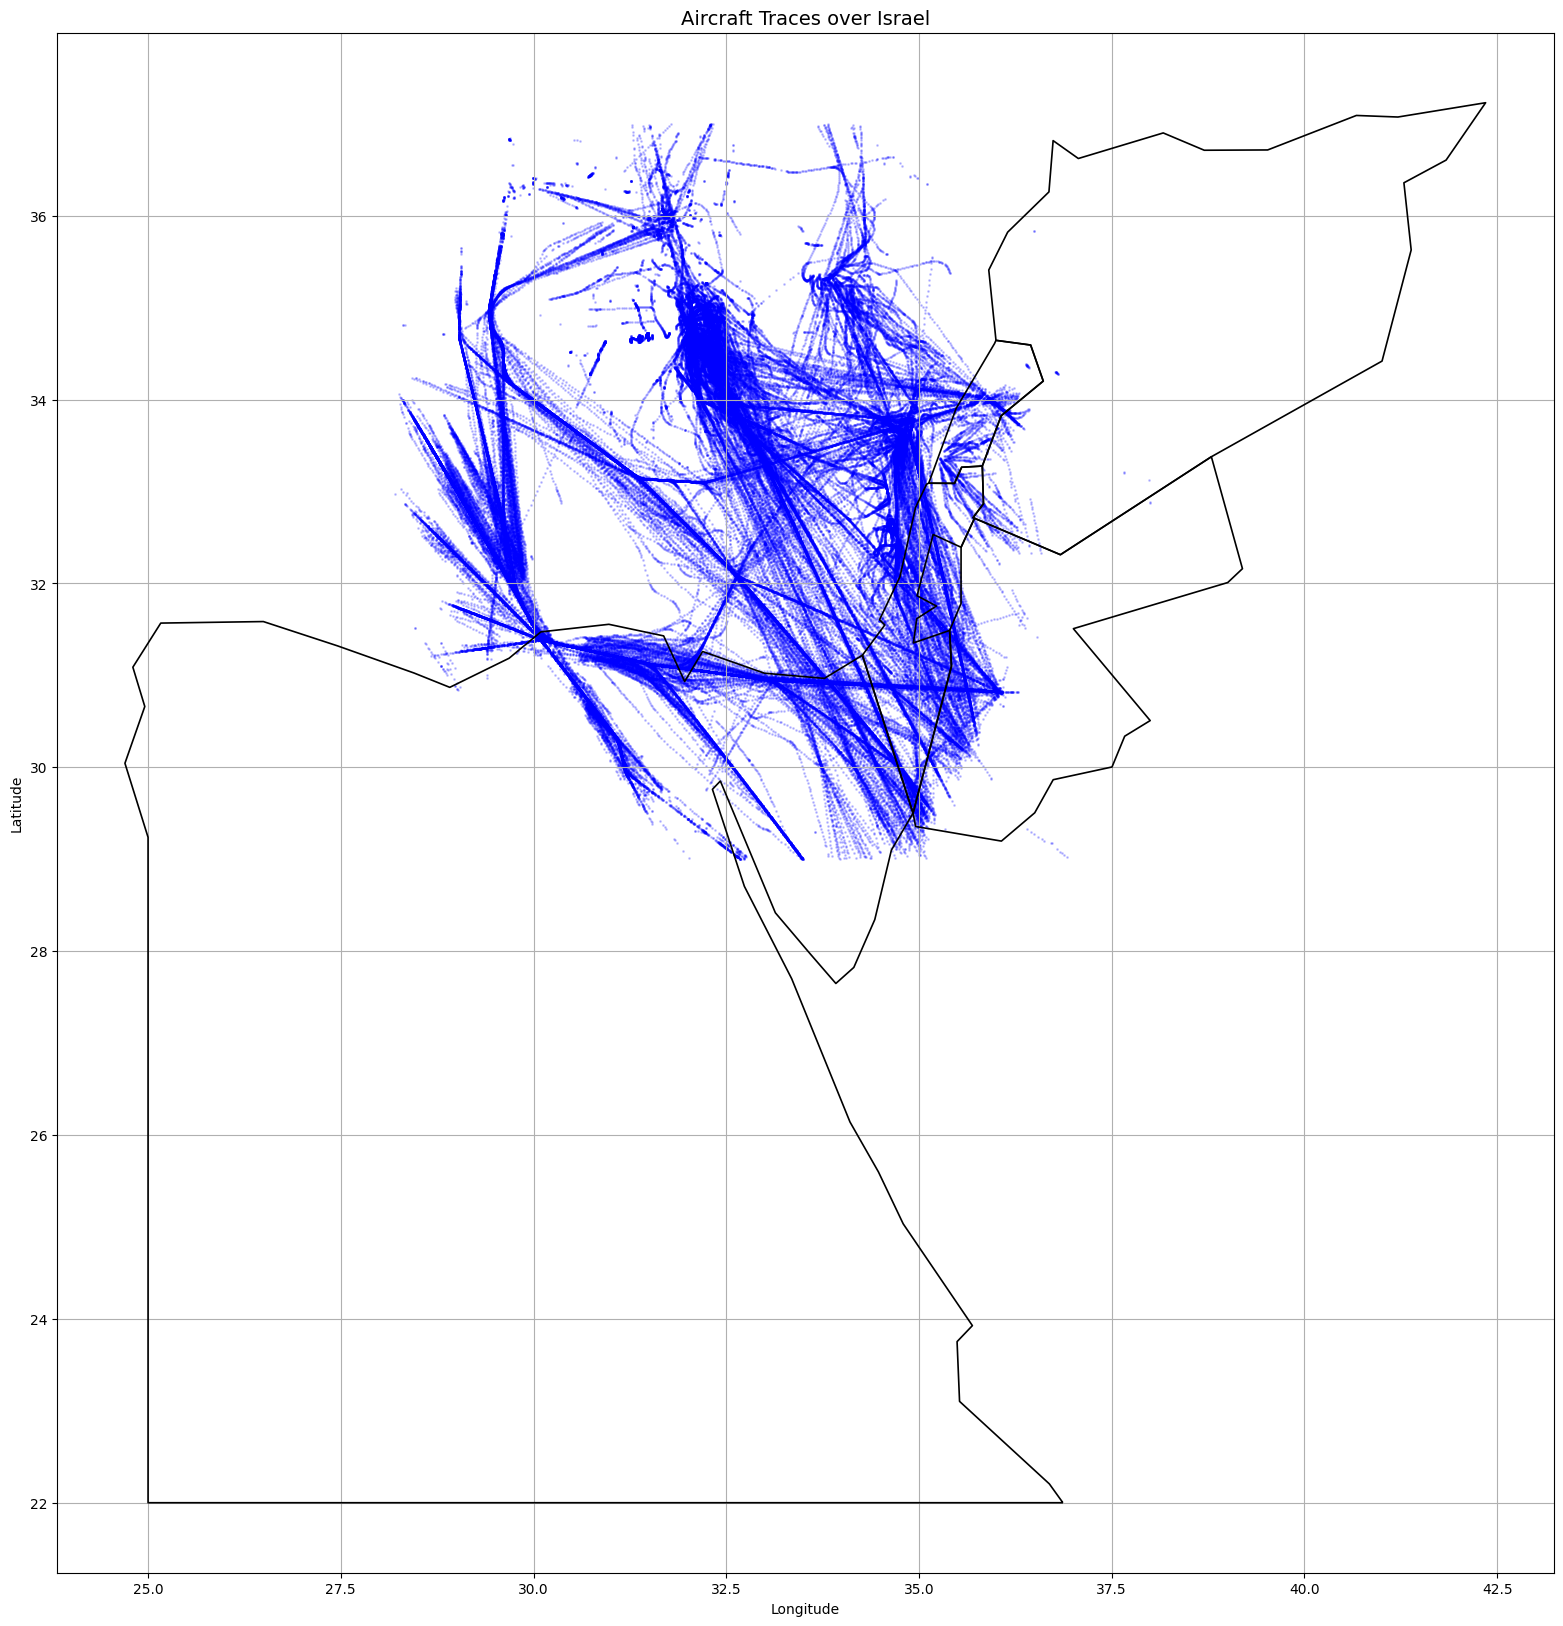

In [7]:
world = gpd.read_file("/kaggle/input/world-map/ne_110m_admin_0_countries.shx")

israel = world[world['ADMIN'] == 'Israel']
israel_neigbors = world[world['ADMIN'].isin(['Israel', 'Jordan', 'Egypt', 'Syria', 'Lebanon'])]

# df = pd.read_csv('adsb_traces_israel_stream.csv')

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['longitude'], df['latitude']),
    crs="EPSG:4326"
)

fig, ax = plt.subplots(figsize=(20, 20))

israel_neigbors.boundary.plot(ax=ax, color='black', linewidth=1.2)

gdf_points.plot(ax=ax, markersize=1, alpha=0.2, color='blue')

ax.set_title('Aircraft Traces over Israel', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# ax.set_xlim([29, 37])
# ax.set_ylim([27, 38])

plt.grid(True)
plt.show()

In [8]:
df = df[(df['longitude'].between(29, 37)) & df['latitude'].between(27, 38)]

## Filter Tracks

In [9]:
tracks_count = df.groupby('segment_id')['timestamp'].count()

In [10]:
tracks_count.describe(percentiles=[0.2])

count    2055.000000
mean      140.073479
std       112.207200
min         1.000000
20%        36.000000
50%       134.000000
max      1843.000000
Name: timestamp, dtype: float64

In [11]:
short_tracks = tracks_count[tracks_count < 100].index

In [12]:
tracks_duration = df.sort_values(['segment_id', 'timestamp'])\
.groupby('segment_id')\
.apply(lambda x: x['timestamp'].max() - x['timestamp'].min())

/tmp/ipykernel_35/1894582104.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['timestamp'].max() - x['timestamp'].min())


In [13]:
tracks_duration.describe()

count    2055.000000
mean     1776.655912
std      1233.366142
min         0.000000
25%       635.815000
50%      1582.960000
75%      2895.060000
max      5584.330000
dtype: float64

In [14]:
short_duration_tracks = tracks_duration[tracks_duration < 60 * 10].index

In [15]:
df = df[(~df['segment_id'].isin(short_tracks)) & (~df['segment_id'].isin(short_duration_tracks))]

In [16]:
tracks_duration = df.sort_values(['segment_id', 'timestamp'])\
.groupby('segment_id')\
.apply(lambda x: x['timestamp'].max() - x['timestamp'].min())
tracks_duration[tracks_duration < 60 * 10].index

/tmp/ipykernel_35/1255470156.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x['timestamp'].max() - x['timestamp'].min())


Index([], dtype='object', name='segment_id')

In [17]:
tracks_count = df.groupby('segment_id')['timestamp'].count()
tracks_count[tracks_count < 50].index

Index([], dtype='object', name='segment_id')

### eda

In [18]:
df.groupby('segment_id')['timestamp'].count().sort_values().iloc[1100:1105]

segment_id
49d3fa_4    308
738284_1    308
738065_4    308
4c808c_0    308
740734_7    309
Name: timestamp, dtype: int64

In [19]:
df['segment_id'].nunique()

1219

temp_track = df[df['icao'] == '46b823']
temp_track.sort_values('timestamp')

<Axes: xlabel='longitude', ylabel='latitude'>

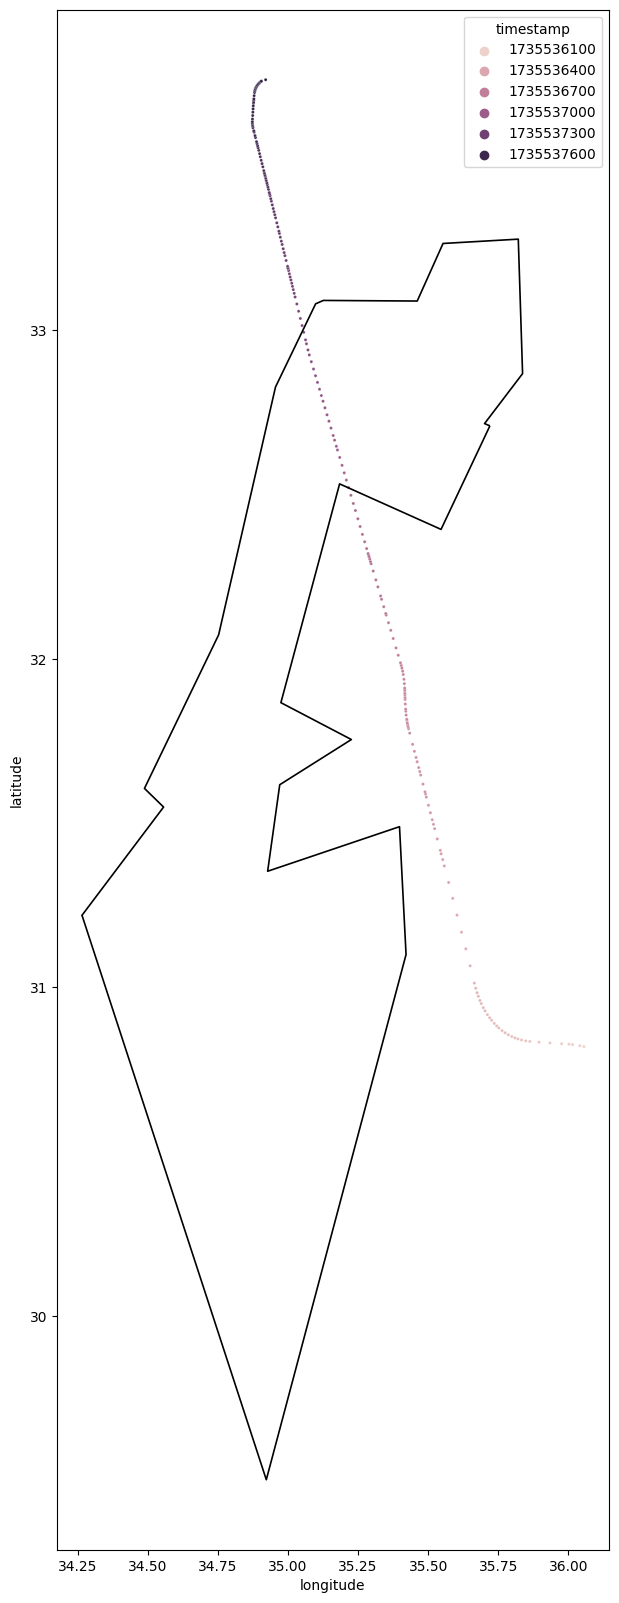

In [20]:
fig, ax = plt.subplots(figsize=(20, 20))

sns.scatterplot(ax=ax, data=df[df['segment_id'] == '471f69_2'], s=5, x='longitude', y='latitude', hue='timestamp')
israel.boundary.plot(ax=ax, color='black', linewidth=1.2)

# Preprocess

In [21]:
def process_flight_tracks(df):
    processed_trajectories = {}

    # Group by ICAO (aircraft ID)
    for icao, group in df.groupby('segment_id'):
        group = group.sort_values('timestamp').reset_index(drop=True)
        
        # Drop rows missing required columns
        group = group.dropna(subset=['longitude', 'latitude', 'altitude', 'timestamp'])

        # Skip if too short
        if len(group) < 100:
            continue

        # Time difference
        dt = group['timestamp'].diff().fillna(1)

        # Compute component velocities
        Vlon = group['longitude'].diff().fillna(0) / dt
        Vlat = group['latitude'].diff().fillna(0) / dt
        Valt = group['altitude'].diff().fillna(0) / dt

        traj = np.stack([
            group['longitude'].values,
            group['latitude'].values,
            group['altitude'].values,
            Vlon.values,
            Vlat.values,
            Valt.values
        ], axis=1)

        processed_trajectories[icao] = traj

    return processed_trajectories

In [22]:
processed_trajectories = process_flight_tracks(df)

In [23]:
len(processed_trajectories)

1219

In [24]:
# def normalize_point(p):
#     return np.array([p[0], p[1], p[2] / 1000])


# Adding epsilon for cos_angle to avoid dividing by 0, straight line expects 0 angle but will be ~0.008
def compute_angles(traj, k=1):
    angles = []
    for i in range(len(traj)):
        if i - k < 0 or i + k >= len(traj):
            angles.append(1e-6)  # padding with 0 if out of bounds
            continue

        # use altitude
        # a = normalize_point(traj[i - k][:3])
        # b = normalize_point(traj[i][:3])
        # c = normalize_point(traj[i + k][:3])

        a = traj[i - k][:2]
        b = traj[i][:2]
        c = traj[i + k][:2]

        ab = b - a
        bc = c - b
        cos_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc) + 1e-8)
        angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))
        angles.append(angle)

    return angles

In [87]:
def behavior_patching(traj, angle_thresh=0.015, patch_size=13, total_patches=15):
    angles = compute_angles(traj)
    active_idxs = [i for i, a in enumerate(angles) if a > angle_thresh]

    # Cluster active points into patches
    clusters = []
    cluster = []
    for idx in active_idxs:
        if cluster and idx - cluster[-1] > 1:
            clusters.append(cluster)
            cluster = []
        cluster.append(idx)
    if cluster:
        clusters.append(cluster)

    behavior_patches = []
    for clust in clusters:
        center = clust[len(clust) // 2]
        start = max(0, center - patch_size // 2)
        end = min(len(traj), start + patch_size)
        patch = traj[start:end]
        if len(patch) == patch_size:
            behavior_patches.append(patch)

    # Select total_pattches overall
    if len(behavior_patches) >= total_patches:
        # Too many behavior patches — randomly keep only total_patches
        behavior_patches = random.sample(behavior_patches, total_patches)
        non_behavioral_patches = []
    else:
        # Fill in the rest with non-behavior patches
        remaining_budget = total_patches - len(behavior_patches)

        # Remaining patches from non-behavioral parts
        non_behavioral_patches = []
        remaining_budget = total_patches - len(behavior_patches)
        available_range = len(traj) - patch_size
    
        # Compute starts to evenly spread remaining patches across the trajectory
        if remaining_budget > 0 and available_range > 0:
            starts = np.linspace(0, len(traj) - patch_size, remaining_budget, dtype=int)
            for i in starts:
                patch = traj[i:i + patch_size]
                if len(patch) == patch_size:
                    non_behavioral_patches.append(patch)
    return (behavior_patches + non_behavioral_patches, list(range(len(behavior_patches)))), len(behavior_patches), len(non_behavioral_patches)

## Determine s threshold for activation plots

In [26]:
angles_list = []
for traj_id in processed_trajectories:
    angles_list.extend(compute_angles(processed_trajectories[traj_id]))

angles_list = np.array(angles_list)

In [27]:
len(angles_list)

253581

In [28]:
pd.Series(angles_list).describe(percentiles=[0.88])

count    253581.000000
mean          0.144799
std           0.427636
min           0.000001
50%           0.009427
88%           0.096959
max           3.139276
dtype: float64

<Axes: >

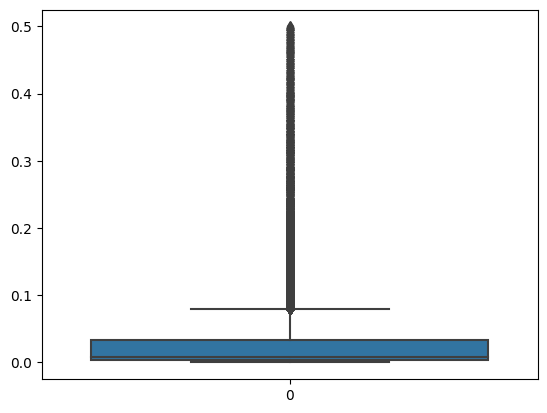

In [29]:
sns.boxplot(angles_list[angles_list < 0.5])

In [30]:
np.rad2deg(0.05)

2.8647889756541165

In [31]:
np.pi/180

0.017453292519943295

## compute pathces

In [88]:
patches = {}
behevior_count = []
non_behevior_count = []
for traj_id in processed_trajectories:
    patches[traj_id], bc, nbc = behavior_patching(processed_trajectories[traj_id])
    behevior_count.append(bc)
    non_behevior_count.append(nbc)

## Understading preprocess
seems tracks are dense it turns

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: title={'center': 'non behevior count'}, ylabel='Count'>

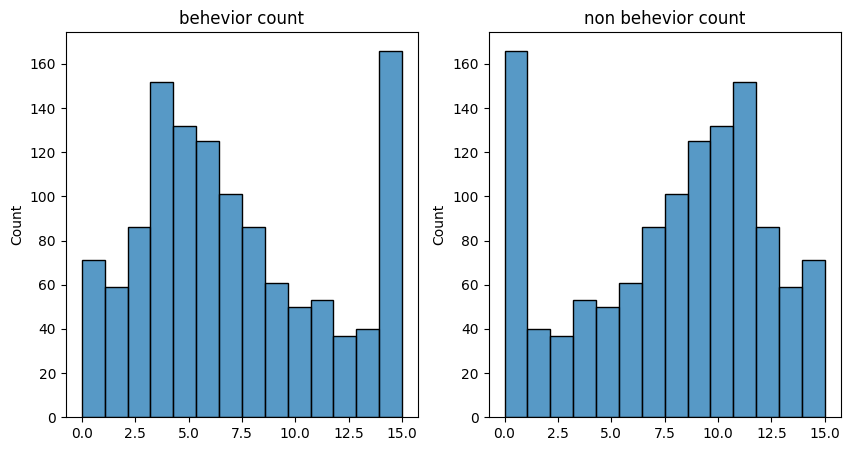

In [89]:
fig, axes = plt.subplots(figsize=(10, 5), ncols=2)
axes[0].set_title('behevior count')
sns.histplot(behevior_count, ax=axes[0])
axes[1].set_title('non behevior count')
sns.histplot(non_behevior_count, ax=axes[1])

<Axes: xlabel='longitude', ylabel='latitude'>

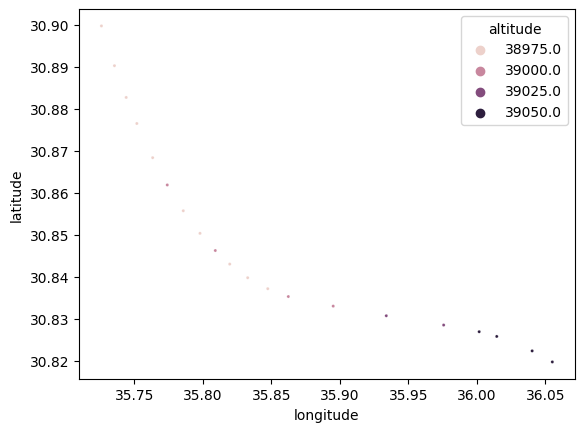

In [34]:
sns.scatterplot(data=df[df['segment_id'] == '471f69_2'].iloc[:20], x='longitude', y='latitude', hue='altitude', s=5)

In [35]:
len(df[df['segment_id'] == '471f69_2'])

225

In [36]:
processed_trajectories['471f69_2'].shape

(225, 6)

In [37]:
patches['471f69_2'], n_patch_behavior, n_patch_non_behavior = behavior_patching(processed_trajectories['471f69_2'])

In [38]:
print(f"n_patch_behavior: {n_patch_behavior} | n_patch_non_behavior: {n_patch_non_behavior}")

n_patch_behavior: 7 | n_patch_non_behavior: 8


In [39]:
processed_trajectories['471f69_2']

array([[ 3.60551740e+01,  3.08198060e+01,  3.90500000e+04,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 3.60404210e+01,  3.08224300e+01,  3.90500000e+04,
        -2.11361031e-03,  3.75931231e-04,  0.00000000e+00],
       [ 3.60145570e+01,  3.08258630e+01,  3.90500000e+04,
        -2.11479967e-03,  2.80703188e-04,  0.00000000e+00],
       ...,
       [ 3.49036580e+01,  3.37573810e+01,  3.15000000e+03,
         7.84976528e-04,  5.87793429e-04, -1.76056338e+01],
       [ 3.49050750e+01,  3.37583520e+01,  3.10000000e+03,
         7.19289330e-04,  4.92893394e-04, -2.53807103e+01],
       [ 3.49201370e+01,  3.37627030e+01,  2.70000000e+03,
         8.49041713e-04,  2.45264938e-04, -2.25479143e+01]])

In [80]:
def behavior_patching_with_indices(traj, angle_thresh=0.02, patch_size=13, total_patches=15):
    angles = compute_angles(traj)
    active_idxs = [i for i, a in enumerate(angles) if a > angle_thresh]

    # Cluster active indices
    clusters = []
    cluster = []
    for idx in active_idxs:
        if cluster and idx - cluster[-1] > 1:
            clusters.append(cluster)
            cluster = []
        cluster.append(idx)
    if cluster:
        clusters.append(cluster)

    behavior_patches = []
    print(f'active clusters: {clusters}')
    for clust in clusters:
        center = clust[len(clust) // 2]
        start = max(0, center - patch_size // 2)
        end = start + patch_size
        if end <= len(traj):
            behavior_patches.append((traj[start:end], start))

    if len(behavior_patches) >= total_patches:
        behavior_patches = random.sample(behavior_patches, total_patches)
        non_behavior_patches = []
    else:
        remaining_budget = total_patches - len(behavior_patches)
        non_behavior_patches = []
        starts = np.linspace(0, len(traj) - patch_size, remaining_budget, dtype=int)
        for i in starts:
            patch = traj[i:i + patch_size]
            if len(patch) == patch_size:
                non_behavior_patches.append((patch, i))

    return behavior_patches + non_behavior_patches, len(behavior_patches), len(non_behavior_patches)  # list of (patch, start_index)

def plot_trajectory_with_patch_indices(traj, indexed_patches, behavior_count):
    fig, axes = plt.subplots(figsize=(12, 18), nrows=3)
    axes = axes.flatten()
    axes[0].plot(traj[:, 0], traj[:, 1], color='gray', linewidth=2, label='Full Trajectory')
    axes[1].plot(traj[:, 0], traj[:, 2], color='gray', linewidth=2, label='Full Trajectory')
    axes[2].plot(traj[:, 1], traj[:, 2], color='gray', linewidth=2, label='Full Trajectory')

    for i, (patch, start_idx) in enumerate(indexed_patches):
        # color = 'red' if i < behavior_count else 'blue'
        # label = 'Behavior Patch' if i == 0 and color == 'red' else 'Non-Behavior Patch' if i == behavior_count else ''
        # plt.plot(traj[start_idx:start_idx+len(patch), 0],
        #          traj[start_idx:start_idx+len(patch), 1],
        #          color=color, linewidth=2, alpha=0.8, label=label)

        if i >= behavior_count:
            label = 'Non-Behavior Patch' if i == 0 else None
            axes[0].plot(traj[start_idx:start_idx+len(patch), 0],
                     traj[start_idx:start_idx+len(patch), 1],
                     color='blue', linewidth=2, alpha=0.8, label=label)
            
            axes[1].plot(traj[start_idx:start_idx+len(patch), 0],
                     traj[start_idx:start_idx+len(patch), 2],
                     color='blue', linewidth=2, alpha=0.8, label=label)
            
            axes[2].plot(traj[start_idx:start_idx+len(patch), 1],
                     traj[start_idx:start_idx+len(patch), 2],
                     color='blue', linewidth=2, alpha=0.8, label=label)
        else:
            label = 'Behavior Patch' if i == 0 else None
            axes[0].plot(traj[start_idx:start_idx+len(patch), 0],
                     traj[start_idx:start_idx+len(patch), 1],
                     color='red', linewidth=2, alpha=0.8, label=label)
            
            axes[1].plot(traj[start_idx:start_idx+len(patch), 0],
                     traj[start_idx:start_idx+len(patch), 2],
                     color='red', linewidth=2, alpha=0.8, label=label)
            
            axes[2].plot(traj[start_idx:start_idx+len(patch), 1],
                     traj[start_idx:start_idx+len(patch), 2],
                     color='red', linewidth=2, alpha=0.8, label=label)

    plt.title("Trajectory Behavior and Non-Behavior Patches")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Altitude")
    axes[2].set_xlabel("Latitude")
    axes[2].set_ylabel("Altitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Choosing total_patches

In [41]:
pd.Series(behevior_count).quantile(0.5) * 13 / pd.Series(df.groupby('segment_id')['latitude'].count()).quantile(0.5)

0.3439153439153439

In [42]:
pd.Series((df.groupby('segment_id')['latitude'].count() / 13) - behevior_count).quantile(0.5)

9.23076923076923

In [43]:
beta = 0.8
beta * pd.Series(behevior_count).quantile(0.95) + (1 - beta) * pd.Series((df.groupby('segment_id')['latitude'].count() / 13) - behevior_count).quantile(0.5)

13.846153846153845

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Count'>

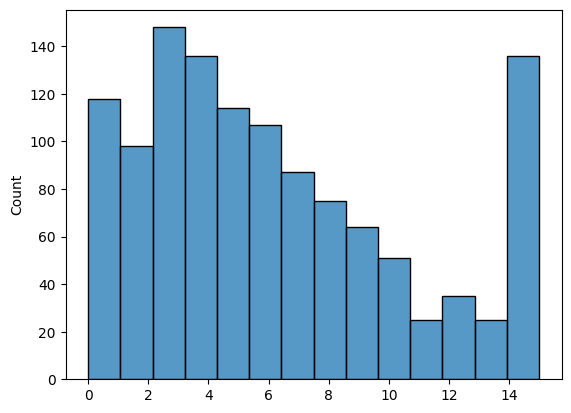

In [44]:
sns.histplot(behevior_count)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='latitude', ylabel='Count'>

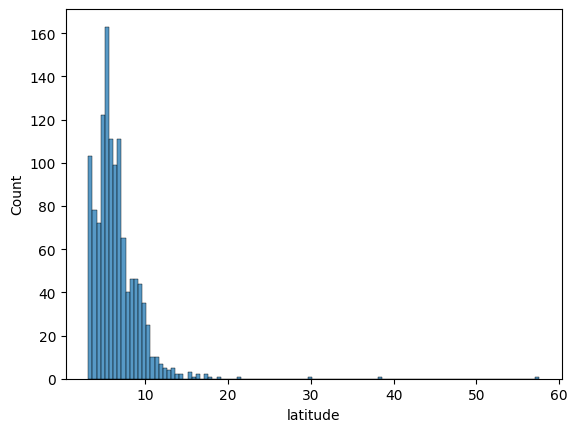

In [45]:
sns.histplot(df.groupby('segment_id')['latitude'].count() / 32)

# Choosing patch_size

In [46]:
trajectory_angles = {
    traj_id: compute_angles(processed_trajectories[traj_id])
    for traj_id in processed_trajectories
}

angle_threshs = np.linspace(0.005, 0.1, 300)
cluster_size = []
active_idxs_size = []


for angle_thresh in angle_threshs:
    all_clusters = []
    all_active_idxs = 0
    
    for angles in trajectory_angles.values():
        active_idxs = np.where(angles > angle_thresh)[0]

        if len(active_idxs) == 0:
            continue

        # 3. Use diff to find splits between clusters
        splits = np.where(np.diff(active_idxs) > 1)[0] + 1
        clusters = np.split(active_idxs, splits)
        cluster_lengths = [len(c) for c in clusters if len(c) > 0]

        all_clusters.extend(cluster_lengths)
        all_active_idxs += len(active_idxs)

    # 4. Compute quantile only once per threshold
    if all_clusters:
        cluster_size.append(np.array(all_clusters))
    active_idxs_size.append(all_active_idxs)
    # else:
    #     cluster_size.append(0)

In [47]:
len(df)

253581

<Axes: >

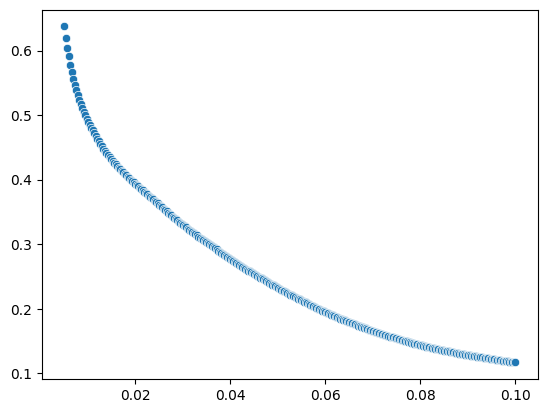

In [48]:
sns.scatterplot(x=angle_threshs, y=np.array(active_idxs_size) / len(df))

<Axes: >

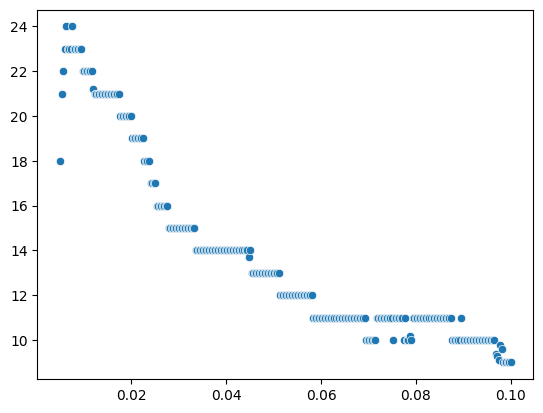

In [49]:
# This is what determined the correct patch_size for a certain threshold (we choose 0.04)
sns.scatterplot(x=angle_threshs, y=[np.quantile(i, 0.9) for i in cluster_size])

In [50]:
import matplotlib.pyplot as plt
from ipywidgets import interact

def plot_hist(i):
    plt.figure(figsize=(6, 4))
    plt.hist(cluster_size[i][np.where(cluster_size[i] < 20)], bins=100, color='skyblue', edgecolor='black')
    plt.title(f'Cluster sizes at angle_thresh={angle_threshs[i]:.5f}')
    plt.xlabel('Cluster Size')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

interact(plot_hist, i=(0, len(cluster_size) - 1))

interactive(children=(IntSlider(value=149, description='i', max=299), Output()), _dom_classes=('widget-interac…

<function __main__.plot_hist(i)>

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='altitude', ylabel='Count'>

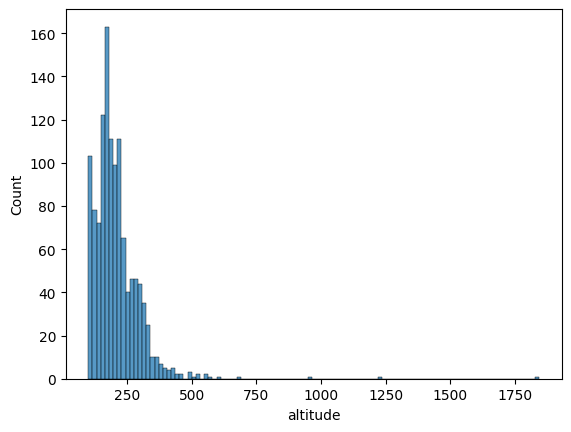

In [51]:
sns.histplot(df.groupby('segment_id')['altitude'].count())

active clusters: [[1, 2, 3], [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28], [58, 59, 60, 61, 62, 63, 64, 65, 66, 67], [70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81], [99, 100], [130, 131], [148, 149], [169, 170, 171], [173, 174, 175, 176, 177, 178, 179, 180], [189, 190], [194, 195, 196, 197, 198, 199, 200, 201], [206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223]]


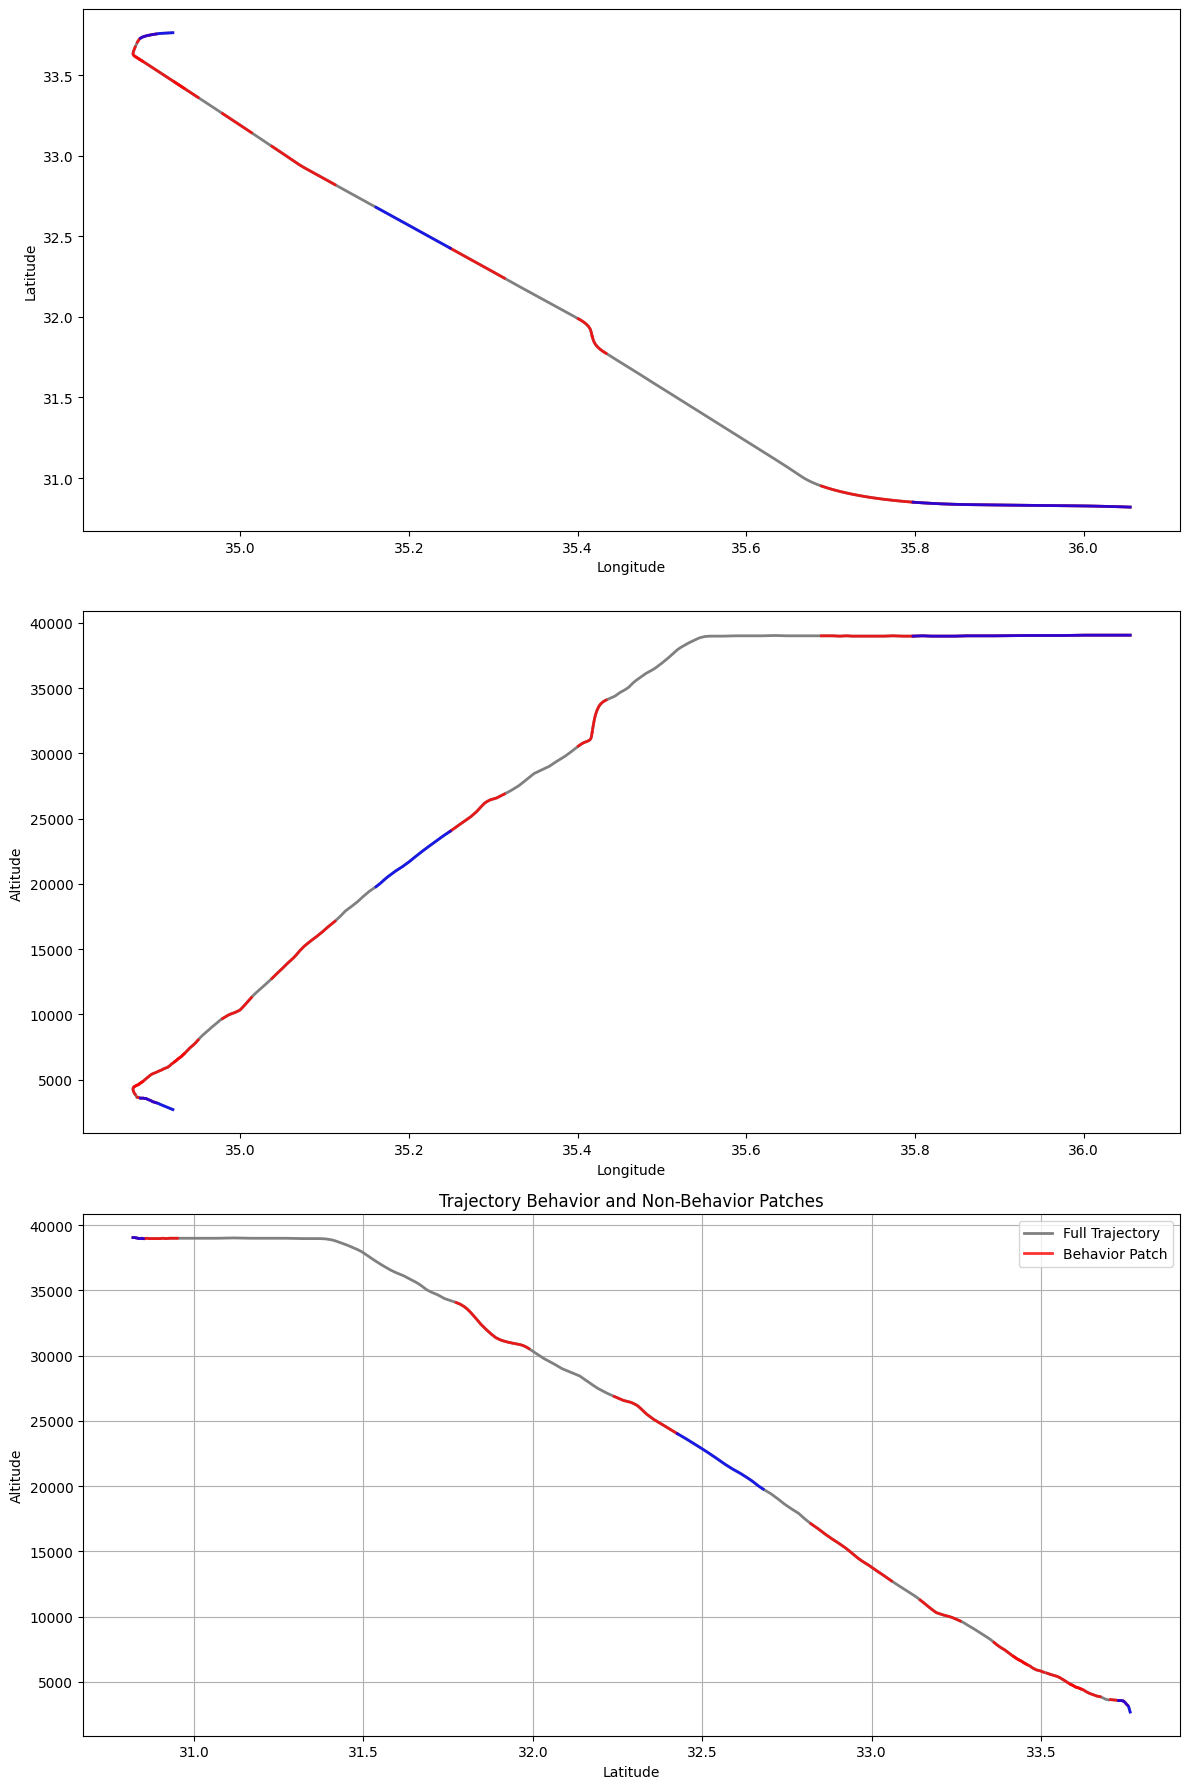

In [77]:
patches_track_sample, n_b, n_nb = behavior_patching_with_indices(processed_trajectories['471f69_2'])
plot_trajectory_with_patch_indices(processed_trajectories['471f69_2'], patches_track_sample, n_b)

In [53]:
n_b

7

# Model

In [54]:
class PatchEncoder(nn.Module):
    def __init__(self, input_dim=6, patch_size=13, dim=256, total_patches=15):
        super().__init__()
        self.projection = nn.Linear(input_dim * patch_size, dim)
        self.pos_embedding = nn.Parameter(torch.randn(1, total_patches, dim))
        self.layer_norm = nn.LayerNorm(dim)

    def forward(self, x):
        # x shape: (batch_size, num_patches, patch_size, input_dim)
        b, n, s, d = x.shape
        x = x.view(b, n, s * d)
        x = self.projection(x) + self.pos_embedding
        x = self.layer_norm(x)
        return x

In [55]:
class FLIGHT2VECModel(nn.Module):
    """Main FLIGHT2VEC model with behavior-adaptive patching and motion trend learning"""
    
    def __init__(self, 
                 input_dim=6, 
                 patch_size=13, 
                 dim=256, 
                 depth=3, 
                 heads=16, 
                 dropout=0.2,
                 total_patches=15):
        super().__init__()
        
        self.input_dim = input_dim
        self.patch_size = patch_size
        self.dim = dim
        
        # Patch encoder
        self.patch_encoder = PatchEncoder(
            input_dim=input_dim, 
            patch_size=patch_size, 
            dim=dim, 
            total_patches=total_patches
        )
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, 
            nhead=heads, 
            dim_feedforward=dim * 4,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        # Reconstruction head for MSE loss
        self.reconstruction_head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, patch_size * input_dim)
        )
        
        # Motion direction prediction head (26 classes)
        self.motion_head = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, 26)
        )
        
        # Global representation pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, patches, mask=None):
        """
        Args:
            patches: Input patches of shape (batch_size, num_patches, patch_size, input_dim)
            mask: Optional mask for masked patches (batch_size, num_patches)
        Returns:
            Dictionary containing representations, reconstructions, and motion logits
        """
        # Encode patches
        x = self.patch_encoder(patches)  # (batch_size, num_patches, dim)
        
        # Apply transformer
        transformer_out = self.transformer(x)  # (batch_size, num_patches, dim)
        
        # Reconstruction for masked patches
        reconstructions = self.reconstruction_head(transformer_out)
        reconstructions = reconstructions.view(-1, transformer_out.size(1), self.patch_size, self.input_dim)
        
        # Motion direction prediction
        motion_logits = self.motion_head(transformer_out)  # (batch_size, num_patches, 26)
        
        # Global representation (average pooling over patches)
        global_repr = transformer_out.mean(dim=1)  # (batch_size, dim)
        
        return {
            'representations': transformer_out,
            'global_representation': global_repr,
            'reconstructions': reconstructions,
            'motion_logits': motion_logits
        }

In [56]:
# class Flight2VecLoss(nn.Module):
#     def __init__(self, lambda_mse=1.0):
#         super().__init__()
#         self.mse = nn.MSELoss()
#         self.ce = nn.CrossEntropyLoss()
#         self.lambda_mse = lambda_mse

#     def forward(self, preds, targets, motion_logits=None, motion_labels=None):
#         mse_loss = self.mse(preds, targets)
#         if motion_logits is not None and motion_labels is not None:
#             direction_loss = self.ce(motion_logits.view(-1, 26), motion_labels.view(-1))
#         else:
#             direction_loss = 0
#         return direction_loss + self.lambda_mse * mse_loss

In [57]:
patches_raw = np.array([np.array(p[0]) for p in patches.values()])
patches_behavior_idxs = [p[1] for p in patches.values()]
patches_raw.shape

(1219, 15, 13, 6)

# Motion Trend Classification 

In [58]:
class MotionDirectionProcessor:
    @staticmethod
    def calculate_motion_directions(trajectories):
        """
        Calculate motion direction classes for a list of trajectories with variable lengths
        Args:
            trajectories: list of np.ndarrays of shape (N, 6) where first 3 dims are [lon, lat, alt]
        Returns:
            list of direction label arrays
        """
        direction_labels = []
        for traj in trajectories:
            coords = traj[:, :3]
            direction_vectors = coords[1:] - coords[:-1]
            # coord_scale = np.std(coords, axis=0)
            # thresholds = np.maximum(coord_scale * 1e-3, 1e-6)
            thresholds = [1e-6, 1e-6, 1e-6]

            labels = []
            for d_vec in direction_vectors:
                d_lon = 1 if d_vec[0] > thresholds[0] else (-1 if d_vec[0] < -thresholds[0] else 0)
                d_lat = 1 if d_vec[1] > thresholds[1] else (-1 if d_vec[1] < -thresholds[1] else 0)
                d_alt = 1 if d_vec[2] > thresholds[2] else (-1 if d_vec[2] < -thresholds[2] else 0)

                direction_tuple = (d_lon + 1, d_lat + 1, d_alt + 1)
                direction_class = direction_tuple[0] * 9 + direction_tuple[1] * 3 + direction_tuple[2]

                if direction_class == 13:
                    direction_class = -1
                elif direction_class > 13:
                    direction_class -= 1

                labels.append(direction_class)
            direction_labels.append(np.array(labels))
        return direction_labels

In [59]:
class MaskingStrategy:
    """Masking strategy for self-supervised learning"""
    
    def __init__(self, behavior_mask_prob=0.6, non_behavior_mask_prob=0.3):
        self.behavior_mask_prob = behavior_mask_prob
        self.non_behavior_mask_prob = non_behavior_mask_prob
    
    def create_mask(self, patches, behavior_indices=None):
        """
        Create mask for patches based on behavior density
        Args:
            patches: Input patches (batch_size, num_patches, patch_size, input_dim)
            behavior_indices: List of behavior patch indices for each batch
        Returns:
            mask: Boolean mask (batch_size, num_patches) - True for masked patches
        """
        batch_size, num_patches = patches.shape[:2]
        mask = torch.zeros(batch_size, num_patches, dtype=torch.bool)
        
        for batch_idx in range(batch_size):
            if behavior_indices is not None and batch_idx < len(behavior_indices):
                behavior_idx = behavior_indices[batch_idx]
            else:
                behavior_idx = []
            
            for patch_idx in range(num_patches):
                if patch_idx in behavior_idx:
                    # Mask behavior patches with higher probability
                    if torch.rand(1).item() < self.behavior_mask_prob:
                        mask[batch_idx, patch_idx] = True
                else:
                    # Mask non-behavior patches with lower probability
                    if torch.rand(1).item() < self.non_behavior_mask_prob:
                        mask[batch_idx, patch_idx] = True
        
        return mask

# class MaskingStrategy:
#     """Improved masking strategy with more conservative probabilities"""
    
#     def __init__(self, behavior_mask_prob=0.4, non_behavior_mask_prob=0.2, min_unmasked=0.3):
#         self.behavior_mask_prob = behavior_mask_prob
#         self.non_behavior_mask_prob = non_behavior_mask_prob
#         self.min_unmasked = min_unmasked  # Ensure at least 30% patches remain unmasked
    
#     def create_mask(self, patches, behavior_indices=None):
#         """
#         Create mask for patches with guaranteed minimum unmasked patches
#         """
#         batch_size, num_patches = patches.shape[:2]
#         mask = torch.zeros(batch_size, num_patches, dtype=torch.bool)
        
#         for batch_idx in range(batch_size):
#             behavior_idx = behavior_indices[batch_idx] if behavior_indices and batch_idx < len(behavior_indices) else []
            
#             # First pass: apply probabilistic masking
#             temp_mask = torch.zeros(num_patches, dtype=torch.bool)
#             for patch_idx in range(num_patches):
#                 if patch_idx in behavior_idx:
#                     if torch.rand(1).item() < self.behavior_mask_prob:
#                         temp_mask[patch_idx] = True
#                 else:
#                     if torch.rand(1).item() < self.non_behavior_mask_prob:
#                         temp_mask[patch_idx] = True
            
#             # Ensure minimum unmasked patches
#             masked_count = temp_mask.sum().item()
#             max_masked = int(num_patches * (1 - self.min_unmasked))
            
#             if masked_count > max_masked:
#                 # Randomly unmask some patches
#                 masked_indices = torch.where(temp_mask)[0]
#                 unmask_count = masked_count - max_masked
#                 unmask_indices = masked_indices[torch.randperm(len(masked_indices))[:unmask_count]]
#                 temp_mask[unmask_indices] = False
            
#             mask[batch_idx] = temp_mask
        
#         return mask

# Train

In [60]:
class FLIGHT2VECTrainer:
    """Training wrapper for FLIGHT2VEC"""
    
    def __init__(self, 
                 model, 
                 optimizer, 
                 criterion, 
                 device='cuda',
                 masking_strategy=None):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.masking_strategy = masking_strategy or MaskingStrategy()
        self.motion_processor = MotionDirectionProcessor()
    
    def train_step(self, patches, behavior_indices=None):
        """
        Single training step
        Args:
            patches: numpy array of patches (batch_size, num_patches, patch_size, input_dim)
            behavior_indices: List of behavior patch indices for each batch
        """
        self.model.train()
        
        # Convert to tensor
        patches_tensor = torch.FloatTensor(patches).to(self.device)
        batch_size, num_patches, patch_size, input_dim = patches_tensor.shape
        
        # Calculate motion direction labels for each patch
        motion_labels = []
        for batch_idx in range(batch_size):
            batch_labels = []
            for patch_idx in range(num_patches):
                patch_data = patches[batch_idx, patch_idx]  # (patch_size, input_dim)
                
                # Calculate motion directions within patch
                if patch_size > 1:
                    patch_directions = self.motion_processor.calculate_motion_directions(
                        patch_data[None, :, :]  # Add batch dimension
                    )[0]  # Remove batch dimension
                    
                    # Use the most common direction in the patch
                    if len(patch_directions) > 0:
                        direction_label = torch.mode(torch.tensor(patch_directions))[0].item()
                    else:
                        direction_label = -1  # Invalid
                else:
                    direction_label = -1  # Invalid for single point
                
                batch_labels.append(direction_label)
            motion_labels.append(batch_labels)
        
        motion_labels_tensor = torch.LongTensor(motion_labels).to(self.device)
        
        # Create mask
        mask = self.masking_strategy.create_mask(patches_tensor, behavior_indices).to(self.device)
        
        # Forward pass
        self.optimizer.zero_grad()
        outputs = self.model(patches_tensor, mask)
        
        # Calculate loss
        loss_dict = self.criterion(
            outputs['reconstructions'],
            patches_tensor,
            outputs['motion_logits'],
            motion_labels_tensor,
            mask
        )
        
        # Backward pass
        loss_dict['total_loss'].backward()
        self.optimizer.step()
        
        return loss_dict
    
    def get_representations(self, patches):
        """
        Extract representations for downstream tasks
        Args:
            patches: numpy array of patches (batch_size, num_patches, patch_size, input_dim)
        Returns:
            Global representations (batch_size, dim)
        """
        self.model.eval()
        
        with torch.no_grad():
            patches_tensor = torch.FloatTensor(patches).to(self.device)
            outputs = self.model(patches_tensor)
            return outputs['global_representation'].cpu().numpy()

# class FLIGHT2VECTrainer:
#     """Improved training wrapper with better data handling and monitoring"""
    
#     def __init__(self, model, optimizer, criterion, device='cuda', masking_strategy=None):
#         self.model = model
#         self.optimizer = optimizer
#         self.criterion = criterion
#         self.device = device
#         self.masking_strategy = masking_strategy or ImprovedMaskingStrategy()
#         self.motion_processor = MotionDirectionProcessor()
        
#         # Training monitoring
#         self.epoch = 0
#         self.losses_history = []
        
#         # Add gradient clipping
#         self.max_grad_norm = 1.0
        
#     def _prepare_motion_labels(patches, original_trajectories=None):
#         batch_size, num_patches, patch_size, input_dim = patches.shape
#         motion_labels = torch.full((batch_size, num_patches), -1, dtype=torch.long)
    
#         if original_trajectories is not None:
#             try:
#                 trajectory_motion_labels = self.motion_processor.calculate_motion_directions(original_trajectories)
    
#                 for batch_idx in range(batch_size):
#                     patch_starts = [int(p[1]) for p in original_trajectories[batch_idx]["patch_indices"]]
#                     patch_size = original_trajectories[batch_idx]["patch_size"]
#                     labels = trajectory_motion_labels[batch_idx]
    
#                     for patch_idx, start_idx in enumerate(patch_starts):
#                         end_idx = min(start_idx + patch_size - 1, len(labels))
#                         patch_labels = labels[start_idx:end_idx]
#                         valid_labels = patch_labels[patch_labels != -1]
    
#                         if len(valid_labels) > 0:
#                             unique_labels, counts = np.unique(valid_labels, return_counts=True)
#                             most_common = unique_labels[np.argmax(counts)]
#                             motion_labels[batch_idx, patch_idx] = most_common
#             except Exception as e:
#                 print(f"Warning: Could not compute motion labels: {e}")
    
#         return motion_labels
    
#     def train_step(self, patches, original_trajectories=None, behavior_indices=None):
#         """
#         Improved training step with better error handling
#         """
#         self.model.train()
        
#         # Validate input shapes
#         if not isinstance(patches, torch.Tensor):
#             patches = torch.FloatTensor(patches)
#         patches = patches.to(self.device)
        
#         batch_size, num_patches, patch_size, input_dim = patches.shape
        
#         # Prepare motion labels
#         motion_labels = self._prepare_motion_labels(patches, original_trajectories)
#         motion_labels = motion_labels.to(self.device)
        
#         # Create mask
#         mask = self.masking_strategy.create_mask(patches, behavior_indices).to(self.device)
        
#         # Ensure at least some patches are masked
#         if mask.sum() == 0:
#             # Force mask at least one patch per batch
#             for batch_idx in range(batch_size):
#                 random_patch = torch.randint(0, num_patches, (1,)).item()
#                 mask[batch_idx, random_patch] = True
        
#         # Forward pass
#         self.optimizer.zero_grad()
        
#         try:
#             outputs = self.model(patches, mask)
            
#             # Set current epoch for loss function
#             if hasattr(self.criterion, 'set_epoch'):
#                 self.criterion.set_epoch(self.epoch)
            
#             # Calculate loss
#             loss_dict = self.criterion(
#                 outputs['reconstructions'],
#                 patches,
#                 outputs['motion_logits'],
#                 motion_labels,
#                 mask
#             )
            
#             # Backward pass with gradient clipping
#             loss_dict['total_loss'].backward()
            
#             # Gradient clipping
#             if self.max_grad_norm > 0:
#                 grad_norm = torch.nn.utils.clip_grad_norm_(
#                     self.model.parameters(), 
#                     self.max_grad_norm
#                 )
#                 loss_dict['grad_norm'] = grad_norm
            
#             self.optimizer.step()
            
#             # Add monitoring info
#             loss_dict['masked_patches_ratio'] = mask.float().mean().item()
#             loss_dict['batch_size'] = batch_size
            
#             return loss_dict
            
#         except Exception as e:
#             print(f"Error in training step: {e}")
#             # Return dummy loss dict to prevent training crash
#             return {
#                 'total_loss': torch.tensor(float('inf')),
#                 'mse_loss': torch.tensor(float('inf')),
#                 'direction_loss': torch.tensor(float('inf')),
#                 'error': str(e)
#             }
    
#         def validate_step(self, patches, original_trajectories=None, behavior_indices=None):
#             """Validation step without gradients"""
#             self.model.eval()
            
#             with torch.no_grad():
#                 if not isinstance(patches, torch.Tensor):
#                     patches = torch.FloatTensor(patches)
#                 patches = patches.to(self.device)
                
#                 motion_labels = self._prepare_motion_labels(patches, original_trajectories)
#                 motion_labels = motion_labels.to(self.device)
                
#                 mask = self.masking_strategy.create_mask(patches, behavior_indices).to(self.device)
                
#                 outputs = self.model(patches, mask)
                
#                 if hasattr(self.criterion, 'set_epoch'):
#                     self.criterion.set_epoch(self.epoch)
                
#                 loss_dict = self.criterion(
#                     outputs['reconstructions'],
#                     patches,
#                     outputs['motion_logits'],
#                     motion_labels,
#                     mask
#                 )

In [61]:
class Flight2VecLoss(nn.Module):
    """Combined loss function for FLIGHT2VEC"""
    
    def __init__(self, lambda_mse=1.0, lambda_direction=1.0):
        super().__init__()
        self.mse_loss = nn.MSELoss()
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=-1)
        self.lambda_mse = lambda_mse
        self.lambda_direction = lambda_direction
    
    def forward(self, 
                reconstructions, 
                original_patches, 
                motion_logits, 
                motion_labels, 
                mask):
        """
        Args:
            reconstructions: Reconstructed patches (batch_size, num_patches, patch_size, input_dim)
            original_patches: Original patches (batch_size, num_patches, patch_size, input_dim)
            motion_logits: Motion direction logits (batch_size, num_patches, 26)
            motion_labels: Motion direction labels (batch_size, num_patches)
            mask: Boolean mask for masked patches (batch_size, num_patches)
        """
        # MSE loss only on masked patches
        masked_reconstructions = reconstructions[mask]
        masked_originals = original_patches[mask]
        mse_loss = self.mse_loss(masked_reconstructions, masked_originals)
        
        # Motion direction loss on all patches
        batch_size, num_patches = motion_logits.shape[:2]
        motion_logits_flat = motion_logits.view(-1, 26)
        motion_labels_flat = motion_labels.view(-1)
        
        # Filter out invalid labels
        valid_mask = motion_labels_flat != -1
        if valid_mask.sum() > 0:
            direction_loss = self.ce_loss(
                motion_logits_flat[valid_mask], 
                motion_labels_flat[valid_mask]
            )
        else:
            direction_loss = torch.tensor(0.0, device=motion_logits.device)
        
        # Combined loss
        total_loss = (self.lambda_direction * direction_loss + 
                     self.lambda_mse * mse_loss)
        
        return {
            'total_loss': total_loss,
            'mse_loss': mse_loss,
            'direction_loss': direction_loss
        }

# class Flight2VecLoss(nn.Module):
#     """Improved loss function with better balancing and monitoring"""
    
#     def __init__(self, lambda_mse=1.0, lambda_direction=0.1, adaptive_weights=True, warmup_epochs=10):
#         super().__init__()
#         self.mse_loss = nn.MSELoss()
#         self.ce_loss = nn.CrossEntropyLoss(ignore_index=-1)
#         self.lambda_mse = lambda_mse
#         self.lambda_direction = lambda_direction
#         self.adaptive_weights = adaptive_weights
#         self.warmup_epochs = warmup_epochs
#         self.current_epoch = 0
        
#     def set_epoch(self, epoch):
#         self.current_epoch = epoch
    
#     def forward(self, reconstructions, original_patches, motion_logits, motion_labels, mask):
#         batch_size = reconstructions.shape[0]
        
#         # MSE loss only on masked patches
#         if mask.sum() > 0:
#             masked_reconstructions = reconstructions[mask]
#             masked_originals = original_patches[mask]
#             mse_loss = self.mse_loss(masked_reconstructions, masked_originals)
#         else:
#             mse_loss = torch.tensor(0.0, device=reconstructions.device, requires_grad=True)
        
#         # Motion direction loss
#         motion_logits_flat = motion_logits.view(-1, motion_logits.size(-1))
#         motion_labels_flat = motion_labels.view(-1)
        
#         valid_mask = motion_labels_flat != -1
#         if valid_mask.sum() > 0:
#             direction_loss = self.ce_loss(
#                 motion_logits_flat[valid_mask], 
#                 motion_labels_flat[valid_mask]
#             )
            
#             # Calculate accuracy for monitoring
#             with torch.no_grad():
#                 pred_classes = motion_logits_flat[valid_mask].argmax(dim=1)
#                 accuracy = (pred_classes == motion_labels_flat[valid_mask]).float().mean()
#         else:
#             direction_loss = torch.tensor(0.0, device=motion_logits.device, requires_grad=True)
#             accuracy = torch.tensor(0.0, device=motion_logits.device)
        
#         # Adaptive loss weighting with warmup
#         warmup_factor = min(1.0, self.current_epoch / self.warmup_epochs)
#         effective_lambda_dir = self.lambda_direction * warmup_factor
        
#         if self.adaptive_weights and mse_loss.item() > 0 and direction_loss.item() > 0:
#             # Balance losses based on their magnitudes
#             mse_magnitude = mse_loss.detach()
#             dir_magnitude = direction_loss.detach()
#             balance_factor = torch.clamp(mse_magnitude / (dir_magnitude + 1e-8), 0.1, 10.0)
#             effective_lambda_dir *= balance_factor
        
#         total_loss = self.lambda_mse * mse_loss + effective_lambda_dir * direction_loss
        
#         return {
#             'total_loss': total_loss,
#             'mse_loss': mse_loss,
#             'direction_loss': direction_loss,
#             'direction_accuracy': accuracy,
#             'effective_lambda_dir': effective_lambda_dir,
#             'num_valid_motion_labels': valid_mask.sum().item()
#         }


# Example usage
def create_flight2vec_model():
    """Create and initialize FLIGHT2VEC model"""
    model = FLIGHT2VECModel(
        input_dim=6,
        patch_size=13,
        dim=256,
        depth=3,
        heads=16,
        dropout=0.2,
        total_patches=15
    )
    
    # Initialize model parameters
    for name, param in model.named_parameters():
        if 'weight' in name and param.dim() > 1:
            nn.init.xavier_uniform_(param)
        elif 'bias' in name:
            nn.init.zeros_(param)
    
    return model

def create_training_setup():
    """Setup training components"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model
    model = create_flight2vec_model().to(device)
    
    # Optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=1e-5,
        weight_decay=1e-4
    )
    
    # Loss function
    criterion = Flight2VecLoss(lambda_mse=1.0, lambda_direction=1.0)
    
    # Trainer
    trainer = FLIGHT2VECTrainer(model, optimizer, criterion, device)
    
    return trainer

# Example training loop
def train_flight2vec(trainer, patches_data, behavior_indices_data, epochs=100, epoch_print_interval=10):
    """
    Train FLIGHT2VEC model
    Args:
        trainer: FLIGHT2VECTrainer instance
        patches_data: List of patch arrays
        behavior_indices_data: List of behavior indices for each sample
        epochs: Number of training epochs
    """
    for epoch in range(epochs):
        total_loss = 0
        num_batches = 0
        
        # Assuming patches_data is a list of batches
        for batch_patches, batch_behavior_indices in zip(patches_data, behavior_indices_data):
            loss_dict = trainer.train_step(batch_patches, batch_behavior_indices)
            total_loss += loss_dict['total_loss'].item()
            num_batches += 1
        
        avg_loss = total_loss / num_batches if num_batches > 0 else 0
        
        if epoch % epoch_print_interval == 0:
            print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")
    
    return trainer

# def create_training_setup():
#     """Create improved training setup with better hyperparameters"""
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
#     # Model with improved architecture
#     model = FLIGHT2VECModel(
#         input_dim=6,
#         patch_size=32,
#         dim=512,  # Larger embedding
#         depth=6,  # More layers
#         heads=8,  # More attention heads
#         dropout=0.1,  # Lower dropout
#         total_patches=64
#     ).to(device)

#     # Initialize model parameters
#     for name, param in model.named_parameters():
#         if 'weight' in name and param.dim() > 1:
#             nn.init.xavier_uniform_(param)
#         elif 'bias' in name:
#             nn.init.zeros_(param)
    
#     # Better optimizer with weight decay
#     optimizer = torch.optim.AdamW(
#         model.parameters(),
#         lr=1e-4,  # Lower learning rate
#         weight_decay=1e-3,
#         betas=(0.9, 0.999)
#     )
    
#     # Improved loss function
#     criterion = Flight2VecLoss(
#         lambda_mse=1.0, 
#         lambda_direction=0.1,  # Lower weight for direction loss
#         adaptive_weights=True,
#         warmup_epochs=10
#     )
    
#     # Improved masking strategy
#     masking_strategy = MaskingStrategy(
#         behavior_mask_prob=0.4,  # More conservative
#         non_behavior_mask_prob=0.2,
#         min_unmasked=0.3
#     )
    
#     # Trainer with improvements
#     trainer = ImprovedFLIGHT2VECTrainer(
#         model, optimizer, criterion, device, masking_strategy
#     )
    
#     return trainer

# def train_flight2vec(trainer, patches_data, trajectories_data=None, behavior_indices_data=None, 
#                             epochs=100, batch_size=16, validation_split=0.2):
#     """
#     Improved training function with validation and monitoring
#     """
#     # Split data for validation
#     total_samples = len(patches_data)
#     val_size = int(total_samples * validation_split)
#     train_size = total_samples - val_size
    
#     # Simple split (in practice, you might want stratified split)
#     train_patches = patches_data[:train_size]
#     val_patches = patches_data[train_size:]
    
#     train_trajectories = trajectories_data[:train_size] if trajectories_data else None
#     val_trajectories = trajectories_data[train_size:] if trajectories_data else None
    
#     train_behavior = behavior_indices_data[:train_size] if behavior_indices_data else None
#     val_behavior = behavior_indices_data[train_size:] if behavior_indices_data else None
    
#     print(f"Training samples: {train_size}, Validation samples: {val_size}")
    
#     # Training loop with monitoring
#     best_val_loss = float('inf')
#     patience = 10
#     patience_counter = 0
    
#     for epoch in range(epochs):
#         trainer.epoch = epoch
        
#         # Training phase
#         trainer.model.train()
#         train_losses = []
        
#         # Create batches for training
#         for i in range(0, len(train_patches), batch_size):
#             batch_patches = train_patches[i:i+batch_size]
#             batch_trajectories = train_trajectories[i:i+batch_size] if train_trajectories else None
#             batch_behavior = train_behavior[i:i+batch_size] if train_behavior else None
            
#             # Convert to tensor if needed
#             if isinstance(batch_patches, list):
#                 batch_patches = torch.stack([torch.tensor(p, dtype=torch.float32) for p in batch_patches])
            
#             loss_dict = trainer.train_step(batch_patches, batch_trajectories, batch_behavior)
            
#             if 'error' not in loss_dict:
#                 train_losses.append({k: v.item() if torch.is_tensor(v) else v for k, v in loss_dict.items()})
        
#         # Validation phase
#         if val_patches:
#             trainer.model.eval()
#             val_losses = []
            
#             for i in range(0, len(val_patches), batch_size):
#                 batch_patches = val_patches[i:i+batch_size]
#                 batch_trajectories = val_trajectories[i:i+batch_size] if val_trajectories else None
#                 batch_behavior = val_behavior[i:i+batch_size] if val_behavior else None
                
#                 if isinstance(batch_patches, list):
#                     batch_patches = torch.stack([torch.tensor(p, dtype=torch.float32) for p in batch_patches])
                
#                 loss_dict = trainer.validate_step(batch_patches, batch_trajectories, batch_behavior)
#                 val_losses.append({k: v.item() if torch.is_tensor(v) else v for k, v in loss_dict.items()})
        
#         # Calculate average losses
#         if train_losses:
#             avg_train_loss = np.mean([l['total_loss'] for l in train_losses if l['total_loss'] != float('inf')])
#             avg_train_mse = np.mean([l['mse_loss'] for l in train_losses if l['mse_loss'] != float('inf')])
#             avg_train_dir = np.mean([l['direction_loss'] for l in train_losses if l['direction_loss'] != float('inf')])
#         else:
#             avg_train_loss = avg_train_mse = avg_train_dir = float('inf')
        
#         if val_losses:
#             avg_val_loss = np.mean([l['total_loss'] for l in val_losses if l['total_loss'] != float('inf')])
#             avg_val_mse = np.mean([l['mse_loss'] for l in val_losses if l['mse_loss'] != float('inf')])
#             avg_val_dir = np.mean([l['direction_loss'] for l in val_losses if l['direction_loss'] != float('inf')])
#         else:
#             avg_val_loss = avg_val_mse = avg_val_dir = float('inf')
        
#         # Print progress
#         if epoch % 5 == 0:
#             print(f"Epoch {epoch}/{epochs}")
#             print(f"  Train - Total: {avg_train_loss:.4f}, MSE: {avg_train_mse:.4f}, Dir: {avg_train_dir:.4f}")
#             if val_losses:
#                 print(f"  Val   - Total: {avg_val_loss:.4f}, MSE: {avg_val_mse:.4f}, Dir: {avg_val_dir:.4f}")
            
#             # Print additional monitoring info
#             if train_losses:
#                 sample_loss = train_losses[-1]
#                 if 'direction_accuracy' in sample_loss:
#                     print(f"  Direction Accuracy: {sample_loss['direction_accuracy']:.3f}")
#                 if 'masked_patches_ratio' in sample_loss:
#                     print(f"  Masked Patches Ratio: {sample_loss['masked_patches_ratio']:.3f}")
#                 if 'num_valid_motion_labels' in sample_loss:
#                     print(f"  Valid Motion Labels: {sample_loss['num_valid_motion_labels']}")
        
#         # Early stopping based on validation loss
#         if val_losses and avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             patience_counter = 0
#             # Save best model
#             torch.save(trainer.model.state_dict(), 'best_flight2vec_model.pth')
#         else:
#             patience_counter += 1
            
#         if patience_counter >= patience:
#             print(f"Early stopping at epoch {epoch} (patience={patience})")
#             break
    
#     return trainer


In [62]:
# Additional debugging utilities
class Flight2VecDebugger:
    """Utility class for debugging FLIGHT2VEC training"""
    
    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
    
    def check_gradients(self):
        """Check if gradients are flowing properly"""
        total_norm = 0
        param_count = 0
        zero_grad_count = 0
        
        for name, param in self.model.named_parameters():
            if param.grad is not None:
                param_norm = param.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
                param_count += 1
                
                if param_norm.item() < 1e-8:
                    zero_grad_count += 1
                    print(f"Very small gradient in {name}: {param_norm.item()}")
            else:
                print(f"No gradient for parameter: {name}")
        
        total_norm = total_norm ** (1. / 2)
        print(f"Total gradient norm: {total_norm}")
        print(f"Parameters with gradients: {param_count}")
        print(f"Parameters with near-zero gradients: {zero_grad_count}")
        
        return total_norm
    
    def analyze_data_batch(self, patches, motion_labels=None):
        """Analyze a batch of data for potential issues"""
        print(f"Batch shape: {patches.shape}")
        print(f"Data range: [{patches.min().item():.6f}, {patches.max().item():.6f}]")
        print(f"Data mean: {patches.mean().item():.6f}, std: {patches.std().item():.6f}")
        
        # Check for NaN or inf values
        nan_count = torch.isnan(patches).sum().item()
        inf_count = torch.isinf(patches).sum().item()
        if nan_count > 0 or inf_count > 0:
            print(f"WARNING: Found {nan_count} NaN and {inf_count} inf values")
        
        # Check motion labels if provided
        if motion_labels is not None:
            unique_labels = torch.unique(motion_labels[motion_labels != -1])
            print(f"Unique motion labels: {unique_labels.tolist()}")
            print(f"Motion label distribution:")
            for label in unique_labels:
                count = (motion_labels == label).sum().item()
                print(f"  Label {label}: {count} occurrences")
    
    def test_forward_pass(self, patches):
        """Test forward pass and check outputs"""
        self.model.eval()
        
        with torch.no_grad():
            try:
                outputs = self.model(patches)
                
                print("Forward pass successful!")
                print(f"Representations shape: {outputs['representations'].shape}")
                print(f"Global representation shape: {outputs['global_representation'].shape}")
                print(f"Reconstructions shape: {outputs['reconstructions'].shape}")
                print(f"Motion logits shape: {outputs['motion_logits'].shape}")
                
                # Check output ranges
                for key, tensor in outputs.items():
                    if torch.is_tensor(tensor):
                        print(f"{key} - range: [{tensor.min().item():.6f}, {tensor.max().item():.6f}]")
                        nan_count = torch.isnan(tensor).sum().item()
                        if nan_count > 0:
                            print(f"  WARNING: {nan_count} NaN values in {key}")
                
            except Exception as e:
                print(f"Forward pass failed: {e}")
                import traceback
                traceback.print_exc()

In [63]:
def create_batches(patches_data: List, behavior_indices_data: List, batch_size: int) -> Tuple[List, List]:
    """
    Create batches from patches and behavior indices data
    Args:
        patches_data: List of patch arrays (each array shape: [64, 32, 6])
        behavior_indices_data: List of behavior indices (each element is a list of variable length)
        batch_size: Size of each batch
    Returns:
        Tuple of (batched_patches, batched_behavior_indices)
    """
    batched_patches = []
    batched_behavior_indices = []
    
    for i in range(0, len(patches_data), batch_size):
        batch_patches = patches_data[i:i + batch_size]
        batch_behavior_indices = behavior_indices_data[i:i + batch_size]
        
        # Handle patches - these should be stackable since they have the same shape
        if isinstance(batch_patches[0], np.ndarray):
            # Stack all patches in the batch into a single tensor
            # Shape: [batch_size, 64, 32, 6]
            batch_patches_tensor = torch.stack([
                torch.tensor(patch, dtype=torch.float32) for patch in batch_patches
            ])
        else:
            # Assume they're already tensors
            batch_patches_tensor = torch.stack(batch_patches)
        
        # Handle behavior indices - these have variable lengths, so keep as list of tensors
        batch_behavior_list = []
        for behavior_idx_list in batch_behavior_indices:
            if isinstance(behavior_idx_list, list):
                # Convert each list to tensor
                behavior_tensor = torch.tensor(behavior_idx_list, dtype=torch.long)
            else:
                # Already a tensor or array
                behavior_tensor = torch.tensor(behavior_idx_list, dtype=torch.long)
            batch_behavior_list.append(behavior_tensor)
        
        batched_patches.append(batch_patches_tensor)
        batched_behavior_indices.append(batch_behavior_list)
    
    return batched_patches, batched_behavior_indices

In [78]:
def run_debugging_session():
    """Run a complete debugging session"""
    print("FLIGHT2VEC Debugging Session")
    print("=" * 50)
    
    # Create model and trainer
    print("\nSetting up model and trainer...")
    trainer = create_training_setup()
    debugger = Flight2VecDebugger(trainer.model, trainer.device)
    
    # Test data analysis
    print("\nAnalyzing sample batch...")
    sample_patches = torch.tensor(patches_raw[0:2], dtype=torch.float32).to(trainer.device)
    debugger.analyze_data_batch(sample_patches)
    
    # Test forward pass
    print("\nTesting forward pass...")
    debugger.test_forward_pass(sample_patches)
    
    # Test training step
    print("\nTesting training step...")
    # try:
    loss_dict = trainer.train_step(
        patches_raw[0:2],
        patches_behavior_idxs[0:2]
    )
    
    print("Training step successful!")
    for key, value in loss_dict.items():
        if torch.is_tensor(value):
            print(f"{key}: {value.item():.6f}")
        else:
            print(f"{key}: {value}")
    
    # Check gradients
    print("\nChecking gradients...")
    debugger.check_gradients()
            
    # except Exception as e:
    #     print(f"Training step failed: {e}")
    #     import traceback
    #     traceback.print_exc()
        
    # Test a few training iterations
    print("\nTesting short training run...")
    batch_patches, batch_behavior_idxs = create_batches(patches_raw[:2], patches_behavior_idxs[:2], batch_size=1)
    try:
        trainer_result = train_flight2vec(
            trainer=trainer,
            patches_data=batch_patches,
            behavior_indices_data=batch_behavior_idxs,
            epochs=100,
            epoch_print_interval=10,
            # batch_size=2,
            # validation_split=0.3
        )
        print("Short training run completed successfully!")
        
    except Exception as e:
        print(f"Training run failed: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    run_debugging_session()

FLIGHT2VEC Debugging Session

Setting up model and trainer...

Analyzing sample batch...
Batch shape: torch.Size([2, 15, 13, 6])
Data range: [-26.486168, 38025.000000]
Data mean: 5075.933105, std: 11724.188477

Testing forward pass...
Forward pass successful!
Representations shape: torch.Size([2, 15, 256])
Global representation shape: torch.Size([2, 256])
Reconstructions shape: torch.Size([2, 15, 13, 6])
Motion logits shape: torch.Size([2, 15, 26])
representations - range: [-2.562436, 2.889782]
global_representation - range: [-2.532560, 2.881734]
reconstructions - range: [-1.954910, 2.190056]
motion_logits - range: [-2.241451, 2.007284]

Testing training step...
Training step successful!
total_loss: 137082288.000000
mse_loss: 137082288.000000
direction_loss: 3.847698

Checking gradients...
Total gradient norm: 78105.84109184789
Parameters with gradients: 49
Parameters with near-zero gradients: 0

Testing short training run...
Epoch 0, Average Loss: 160375040.0000
Epoch 10, Average Loss

In [90]:
# def train_flight2vec(trainer, patches_data, behavior_indices_data, epochs=100, batch_size=32):
#     """
#     Train FLIGHT2VEC model
#     Args:
#         trainer: FLIGHT2VECTrainer instance
#         patches_data: List of patch arrays
#         behavior_indices_data: List of behavior indices for each sample
#         epochs: Number of training epochs
#         batch_size: Batch size for training
#     """
#     # Create batches
#     print(f"Creating batches with batch_size={batch_size}")
#     batched_patches, batched_behavior_indices = create_batches(
#         patches_data, behavior_indices_data, batch_size
#     )
    
#     print(f"Total samples: {len(patches_data)}")
#     print(f"Number of batches: {len(batched_patches)}")
    
#     for epoch in range(epochs):
#         total_loss = 0
#         num_batches = 0
        
#         # Iterate through batches
#         for batch_idx, (batch_patches, batch_behavior_indices) in enumerate(
#             zip(batched_patches, batched_behavior_indices)
#         ):
#             try:
#                 loss_dict = trainer.train_step(batch_patches, batch_behavior_indices)
                
#                 # Handle loss extraction more robustly
#                 if isinstance(loss_dict['total_loss'], torch.Tensor):
#                     if loss_dict['total_loss'].numel() == 1:
#                         batch_loss = loss_dict['total_loss'].item()
#                     else:
#                         # If tensor has multiple elements, take the mean
#                         batch_loss = loss_dict['total_loss'].mean().item()
#                 else:
#                     # If it's already a scalar
#                     batch_loss = float(loss_dict['total_loss'])
                
#                 total_loss += batch_loss
#                 num_batches += 1
                
#                 # Print batch progress occasionally
#                 if batch_idx % 20 == 0 and epoch % 10 == 0:
#                     print(f"  Batch {batch_idx}/{len(batched_patches)}, Loss: {batch_loss:.4f}")
                    
#             except Exception as e:
#                 print(f"Error in batch {batch_idx}: {e}")
#                 import traceback
#                 traceback.print_exc()
#                 continue
        
#         avg_loss = total_loss / num_batches if num_batches > 0 else 0
        
#         if epoch % 10 == 0:
#             print(f"Epoch {epoch}/{epochs}, Average Loss: {avg_loss:.4f}")
    
#     return trainer

def validate_data(patches_raw, patches_behavior_idxs):
    """
    Validate input data before training
    """
    if len(patches_raw) != len(patches_behavior_idxs):
        raise ValueError(f"Mismatch in data lengths: patches={len(patches_raw)}, behavior_indices={len(patches_behavior_idxs)}")
    
    if len(patches_raw) == 0:
        raise ValueError("No training data provided")
    
    print(f"Data validation passed: {len(patches_raw)} samples")
    
    # Print sample shapes
    if hasattr(patches_raw[0], 'shape'):
        print(f"Sample patch shape: {patches_raw[0].shape}")
    if hasattr(patches_behavior_idxs[0], '__len__'):
        print(f"Sample behavior indices length: {len(patches_behavior_idxs[0])}")
        
    # Show distribution of behavior indices lengths
    behavior_lengths = [len(idx_list) for idx_list in patches_behavior_idxs]
    print(f"Behavior indices lengths - Min: {min(behavior_lengths)}, Max: {max(behavior_lengths)}, Avg: {np.mean(behavior_lengths):.2f}")
    
    # Show a few examples
    print(f"First few behavior indices: {patches_behavior_idxs[:3]}")

# Main training function
def main():
    """
    Main training function with proper data handling and batching
    """
    print("Starting FLIGHT2VEC Training")
    print("=" * 50)
    
    # Training parameters
    BATCH_SIZE = 16  # Adjust based on your GPU memory
    EPOCHS = 100
    LEARNING_RATE = 0.05
    
    try:
        # Setup training (assuming this function exists)
        print("Setting up trainer...")
        trainer = create_training_setup()  # You'll need to implement this

        patches_raw = np.array([np.array(p[0]) for p in patches.values()])
        patches_behavior_idxs = [p[1] for p in patches.values()]
        
        # Validate data
        validate_data(patches_raw, patches_behavior_idxs)
        
        # Train the model
        print(f"\nStarting training with:")
        print(f"  Batch size: {BATCH_SIZE}")
        print(f"  Epochs: {EPOCHS}")
        print(f"  Samples: {len(patches_raw)}")
        print("-" * 30)

        batch_patches, batch_behavior_idxs = create_batches(patches_raw, patches_behavior_idxs, batch_size=BATCH_SIZE)
        trained_trainer = train_flight2vec(
            trainer=trainer,
            patches_data=batch_patches,
            behavior_indices_data=batch_behavior_idxs,
            epochs=EPOCHS
        )
        
        print("\nTraining completed successfully!")
        
        # Save the trained model (optional)
        torch.save(trained_trainer.model.state_dict(), 'flight2vec_model.pth')
        print("Model saved to 'flight2vec_model_1.pth'")
        
    except Exception as e:
        print(f"Training failed with error: {e}")
        raise

if __name__ == "__main__":
    main()

Starting FLIGHT2VEC Training
Setting up trainer...
Data validation passed: 1219 samples
Sample patch shape: (15, 13, 6)
Sample behavior indices length: 2
Behavior indices lengths - Min: 0, Max: 15, Avg: 7.31
First few behavior indices: [[0, 1], [0], [0]]

Starting training with:
  Batch size: 16
  Epochs: 100
  Samples: 1219
------------------------------
Epoch 0, Average Loss: 146934623.9740
Epoch 10, Average Loss: 147894471.7662
Epoch 20, Average Loss: 146345426.2338
Epoch 30, Average Loss: 147444403.4805
Epoch 40, Average Loss: 146386944.5974
Epoch 50, Average Loss: 146799532.4675
Epoch 60, Average Loss: 146949510.9610
Epoch 70, Average Loss: 145078391.1429
Epoch 80, Average Loss: 144337968.6753
Epoch 90, Average Loss: 144526705.5325

Training completed successfully!
Model saved to 'flight2vec_model_1.pth'


In [ ]:
# TODO make sure to maximize behavior patches - maybe choose more representative tracks
# TODO debug motion detector processor and masking